#  GAN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://www.kaggle.com/datasets/splcher/animefacedataset
* https://github.com/eriklindernoren/PyTorch-GAN

## Задачи для совместного разбора

1\. Обсудите основные шаги в обучении GAN.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
noise = th.rand(size=(1, 100, 1, 1))

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(in_channels=100, out_channels=8, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=4, stride=2, padding=1),
    nn.ReLU()
)

In [ ]:
img_gen = generator(noise)
img_gen.shape

torch.Size([1, 3, 4, 4])

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 8, 3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(32, 2)
)
discriminator(img_gen)

tensor([[-0.1076,  0.0348]], grad_fn=<AddmmBackward0>)

## Задачи для самостоятельного решения

In [ ]:
import os
from PIL import Image
import torch as th
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as T
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<p class="task" id="1"></p>

1\. Создайте набор данных на основе архива `anime.zip`. Используя преобразования `torchvision`, приведите изображения к одному размеру и нормализуйте их. Выведите на экран несколько примеров изображений.

- [ ] Проверено на семинаре

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/данные/anime.zip', 'r') as ZIP:
  ZIP.extractall('anime/')

In [ ]:
class AnimeDataset:
  def __init__(self, path_folder, transforms=None):
    self.root = path_folder
    self.files = os.listdir(path_folder)
    if transforms is None:
      self.transforms = T.Compose([
          T.ToTensor()
      ])
    else:
      self.transforms = transforms

  def __getitem__(self, idx):
    img = Image.open(f'{self.root}/{self.files[idx]}')
    img_t = self.transforms(img)
    return img_t

  def __len__(self):
    return len(self.files)

In [ ]:
trans = T.Compose([
    T.Resize((200, 200)),
    T.ToTensor()
])
anime_dset = AnimeDataset('anime/images', transforms=trans)
loader = DataLoader(anime_dset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
from tqdm import tqdm
psum    = th.tensor([0.0, 0.0, 0.0])
psum_sq = th.tensor([0.0, 0.0, 0.0])

for inputs in tqdm(loader):
    psum    += inputs[0].sum(axis        = [1, 2])
    psum_sq += (inputs[0] ** 2).sum(axis = [1, 2])

image_size = 300
count = len(anime_dset) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = th.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 1987/1987 [02:30<00:00, 13.19it/s]


mean: tensor([0.0096, 0.0082, 0.0079])
std:  tensor([0.0873, 0.0767, 0.0738])


In [ ]:
total_mean = th.tensor([0.0096, 0.0082, 0.0079])
total_std = th.tensor([0.0873, 0.0767, 0.0738])

In [ ]:
trans = T.Compose([
    T.Resize((200, 200)),
    T.ToTensor(),
    T.Normalize(total_mean, total_std)
])
anime_dset = AnimeDataset('anime/images', transforms=trans)
loader = DataLoader(anime_dset, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt

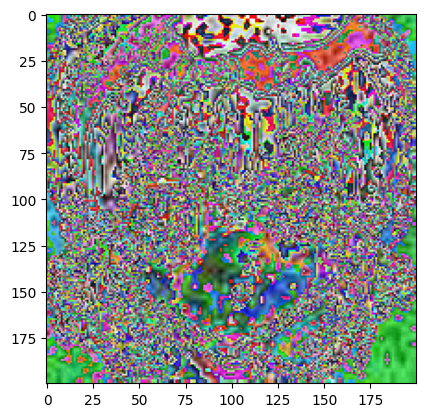

In [ ]:
img = anime_dset[0]
plt.imshow(T.ToPILImage()(img));

<p class="task" id="2"></p>

2\. Реализуйте архитектуру `DCGAN` и обучите модель. Подберите гиперпараметры таким образом, чтобы получаемые изображения стали достаточного качественными (четкими и без существенных дефектов). Во время обучения сохраняйте примеры генерации изображений из случайного шума и сравните, как менялось качество получаемых изображений в процессе обучения.

- [ ] Проверено на семинаре

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        th.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        th.nn.init.normal_(m.weight.data, 1.0, 0.02)
        th.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
from dataclasses import dataclass
@dataclass
class Config:
    n_epoch = 3
    lr = 0.001
    img_size = 32
    latent_dim = 100
    batch_size = 64
    b1 = 0.5
    b2 = 0.999
    n_cpu = 8
    channels = 3
    device = 'cuda'

opt = Config()

In [ ]:
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Initialize weights
if opt.device == 'cuda':
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
trans = T.Compose([
    T.Resize(opt.img_size),
    T.ToTensor(),
    T.Normalize(th.tensor([0.5, 0.5, 0.5]), th.tensor([0.3, 0.3, 0.3]))
])
anime_dset = AnimeDataset('anime/images', transforms=trans)
loader = DataLoader(anime_dset, batch_size=opt.batch_size)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = th.cuda.FloatTensor if opt.device == 'cuda' else th.FloatTensor

In [ ]:
from torch.autograd import Variable
import numpy as np

In [ ]:
for epoch in range(opt.n_epoch):
    for imgs in loader:
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, opt.n_epoch, d_loss.item(), g_loss.item())
    )

[Epoch 1/3] [D loss: 0.002698] [G loss: 5.089397]
[Epoch 2/3] [D loss: 0.000036] [G loss: 12.479497]
[Epoch 3/3] [D loss: 0.000083] [G loss: 11.067070]


In [ ]:
z = Variable(Tensor(np.random.normal(0, 1, (1, opt.latent_dim))))
gen_img = generator(z)
gen_img.shape

torch.Size([1, 3, 32, 32])

In [ ]:
invert_normalize = T.Compose(
    [
        T.Normalize(mean=[-0.5/0.3, -0.5/0.3, -0.5/0.3],
                                         std=[1/0.3, 1/0.3, 1/0.3]),
    ]
)
img = invert_normalize(gen_img.detach().cpu().squeeze())
img.shape

torch.Size([3, 32, 32])

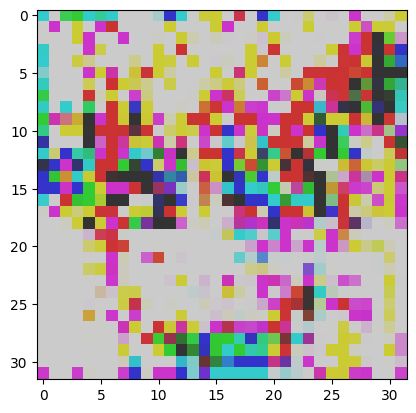

In [ ]:
plt.imshow(img.permute(1, 2, 0));

<p class="task" id="3"></p>

3\. Создайте наборы данных на основе архива `summer2winter_yosemite.zip`. Используя преобразования `torchvision`, приведите изображения к одному размеру и нормализуйте их. Выведите на экран несколько примеров изображений, расположив изображения из одной пары рядом по горизонтали.

- [ ] Проверено на семинаре

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/данные/summer2winter_yosemite.zip") as ZIP:
  ZIP.extractall()

In [ ]:
class SummerWinterDataset:
  def __init__(self, root, transforms):
    self.root = root
    self.max_len = min(len(os.listdir(f'{root}/A')), len(os.listdir(f'{root}/B')))
    self.A = sorted(os.listdir(f'{root}/A'))[:self.max_len]
    self.B = sorted(os.listdir(f'{root}/B'))[:self.max_len]
    self.transforms = transforms

  def __getitem__(self, idx):
    img = Image.open(f'{self.root}/A/{self.A[idx]}')
    img_t = self.transforms(img)
    img2 = Image.open(f'{self.root}/B/{self.B[idx]}')
    img2_t = self.transforms(img2)
    return img_t, img2_t

  def __len__(self):
    return self.max_len

In [ ]:
trans = T.Compose([
    T.Resize((200, 200)),
    T.PILToTensor()
])
dset = SummerWinterDataset('/content/summer2winter_yosemite/train', transforms=trans)
loader = DataLoader(dset, batch_size=32)

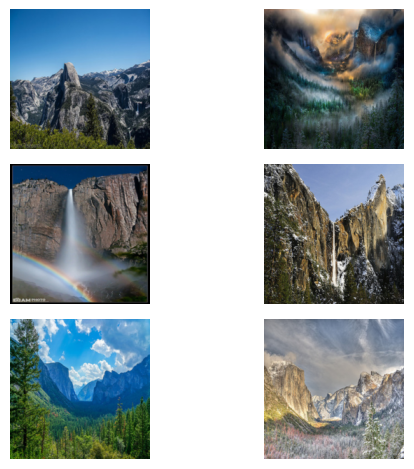

In [ ]:
def show_images(n_images):
  fig, ax = plt.subplots(nrows=n_images, ncols=2)
  for i in range(n_images):
    idx = th.randint(0, len(dset), size=(1,))
    img, img2 = dset[idx]
    ax[i][0].imshow(img.permute(1, 2, 0))
    ax[i][0].axis('off')
    ax[i][1].imshow(img2.permute(1, 2, 0));
    ax[i][1].axis('off');
  plt.tight_layout()

show_images(3)

<p class="task" id="4"></p>

4\. Реализуйте архитектуру `CycleGAN` и обучите модель. Подберите гиперпараметры таким образом, чтобы получаемые изображения стали достаточного качественными (четкими и без существенных дефектов). Во время обучения сохраняйте примеры преобразования (в обе стороны) и  сравните, как менялось качество получаемых изображений в процессе обучения.

- [ ] Проверено на семинаре

In [ ]:
import random
import time
import datetime
import sys

import itertools
from torchvision.utils import save_image, make_grid

from torch.autograd import Variable

from torchvision.utils import save_image


class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = th.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(th.cat(to_return))

In [ ]:
import torch.nn.functional as F
import numpy as np


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        th.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            th.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        th.nn.init.normal_(m.weight.data, 1.0, 0.02)
        th.nn.init.constant_(m.bias.data, 0.0)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
from dataclasses import dataclass
@dataclass
class ConfigCycleGAN:
    epoch = 0
    n_epochs = 5
    batch_size = 1
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    decay_epoch = 100
    n_cpu = 8
    img_height = 32
    img_width = 32
    channels = 3
    sample_interval = 100
    checkpoint_interval = -1
    n_residual_blocks = 9
    lambda_cyc = 10.0
    lambda_id = 5.0

opt = ConfigCycleGAN()

In [ ]:
# Losses
criterion_GAN = th.nn.MSELoss()
criterion_cycle = th.nn.L1Loss()
criterion_identity = th.nn.L1Loss()

cuda = th.cuda.is_available()

input_shape = (opt.channels, opt.img_height, opt.img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = th.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = th.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = th.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = th.cuda.FloatTensor if cuda else th.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Image transformations
transforms_ = [
    T.Resize(int(opt.img_height * 1.12), Image.BICUBIC),
    T.RandomCrop((opt.img_height, opt.img_width)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
trans = T.Compose([
    T.Resize(int(opt.img_height * 1.12), Image.BICUBIC),
    T.RandomCrop((opt.img_height, opt.img_width)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dset = SummerWinterDataset('/content/summer2winter_yosemite/train', transforms=trans)
loader = DataLoader(dset, batch_size=16, shuffle=True)

res_img = []
for epoch in range(opt.epoch, opt.n_epochs):
    for batch in loader:

        # Set model input
        real_A = Variable(batch[0].type(Tensor))
        real_B = Variable(batch[1].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        # ------------------
        #  Train Generators
        # ------------------
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        res_img.append(fake_A)
        res_img.append(fake_A)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()
        # -----------------------
        #  Train Discriminator A
        # -----------------------
        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()
        # -----------------------
        #  Train Discriminator B
        # -----------------------
        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2
    res_img.append(fake_A[0])
    res_img.append(fake_B[0])
    print(
        "[Epoch %d/%d] [loss: %f]"
        % (epoch+1, opt.n_epochs, loss_D_B.item())
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


[Epoch 1/5] [loss: 0.280185]
[Epoch 2/5] [loss: 0.234441]
[Epoch 3/5] [loss: 0.207139]
[Epoch 4/5] [loss: 0.252816]
[Epoch 5/5] [loss: 0.119067]


In [ ]:
# res_img = [i[0] for i in res_img]
res_img[-5].shape

torch.Size([16, 3, 32, 32])

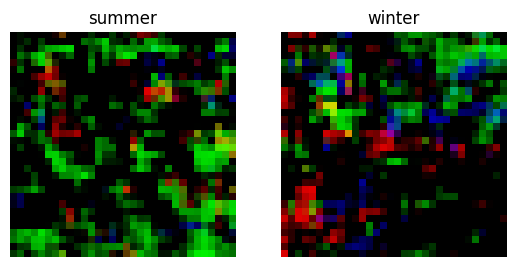

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(res_img[0][0].permute(1, 2, 0).detach().cpu())
ax[1].imshow(res_img[1][0].permute(1, 2, 0).detach().cpu())
ax[0].set_title('summer')
ax[1].set_title('winter')
ax[0].axis('off')
ax[1].axis('off');

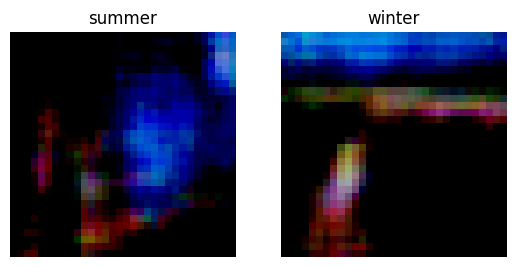

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(res_img[-1].permute(1, 2, 0).detach().cpu())
ax[1].imshow(res_img[-2].permute(1, 2, 0).detach().cpu())
ax[0].set_title('summer')
ax[1].set_title('winter')
ax[0].axis('off')
ax[1].axis('off');

## Обратная связь
- [ ] Хочу получить обратную связь по решению